This notebook is to help learners like myself to understand how we can use time series forecasting to solve business problems. The data and scenario are from Udacity's course on time series forecasting which is a part of the predictive analytics nanodegree. You can find more info regarding the course [here](https://www.udacity.com/course/predictive-analytics-for-business-nanodegree--nd008).


## Scenario:

You recently started working as a Business Analyst for a company that creates and sells video games. Your manager discusses a business problem with you and tasks you to come up with a solution.

The problem at hand is that the company's ordering method is not as efficient as it should be. The company is having a hard time trying to predict demand so that it can match ordering supplies to meet the need of its customers. The company doesn't want to bloat the demand estimation and end up with piles of unused stock. Similary they don't want to underestimate demand and run the risk of losing customers to competition. 

Your manager has tasked you to forecast monthly sales data in order to synchronize supply with demand, aid in decision making that will help build a competitive infrastructure and measure company performance. You, the business analyst, are assigned to help your manager run the numbers through a time series forecasting model.

You’ve been asked to provide a forecast for the next 4 months of sales and report your findings.


### Note: 

During the course of this notebook I will use multiple time series model. I will try to explain them as simply as possible. To understand it further and in more detail I will post links to materials that I have found really helpful.

Initially I had solved the problems using Alteryx. I have posted the screenshot of the workflow below for anyone that might be interested is using Alteryx to create a workflow. 

In [1]:
import pandas as pd
import seaborn as sns
import os
from IPython.display import Image

C:\Users\hamza\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


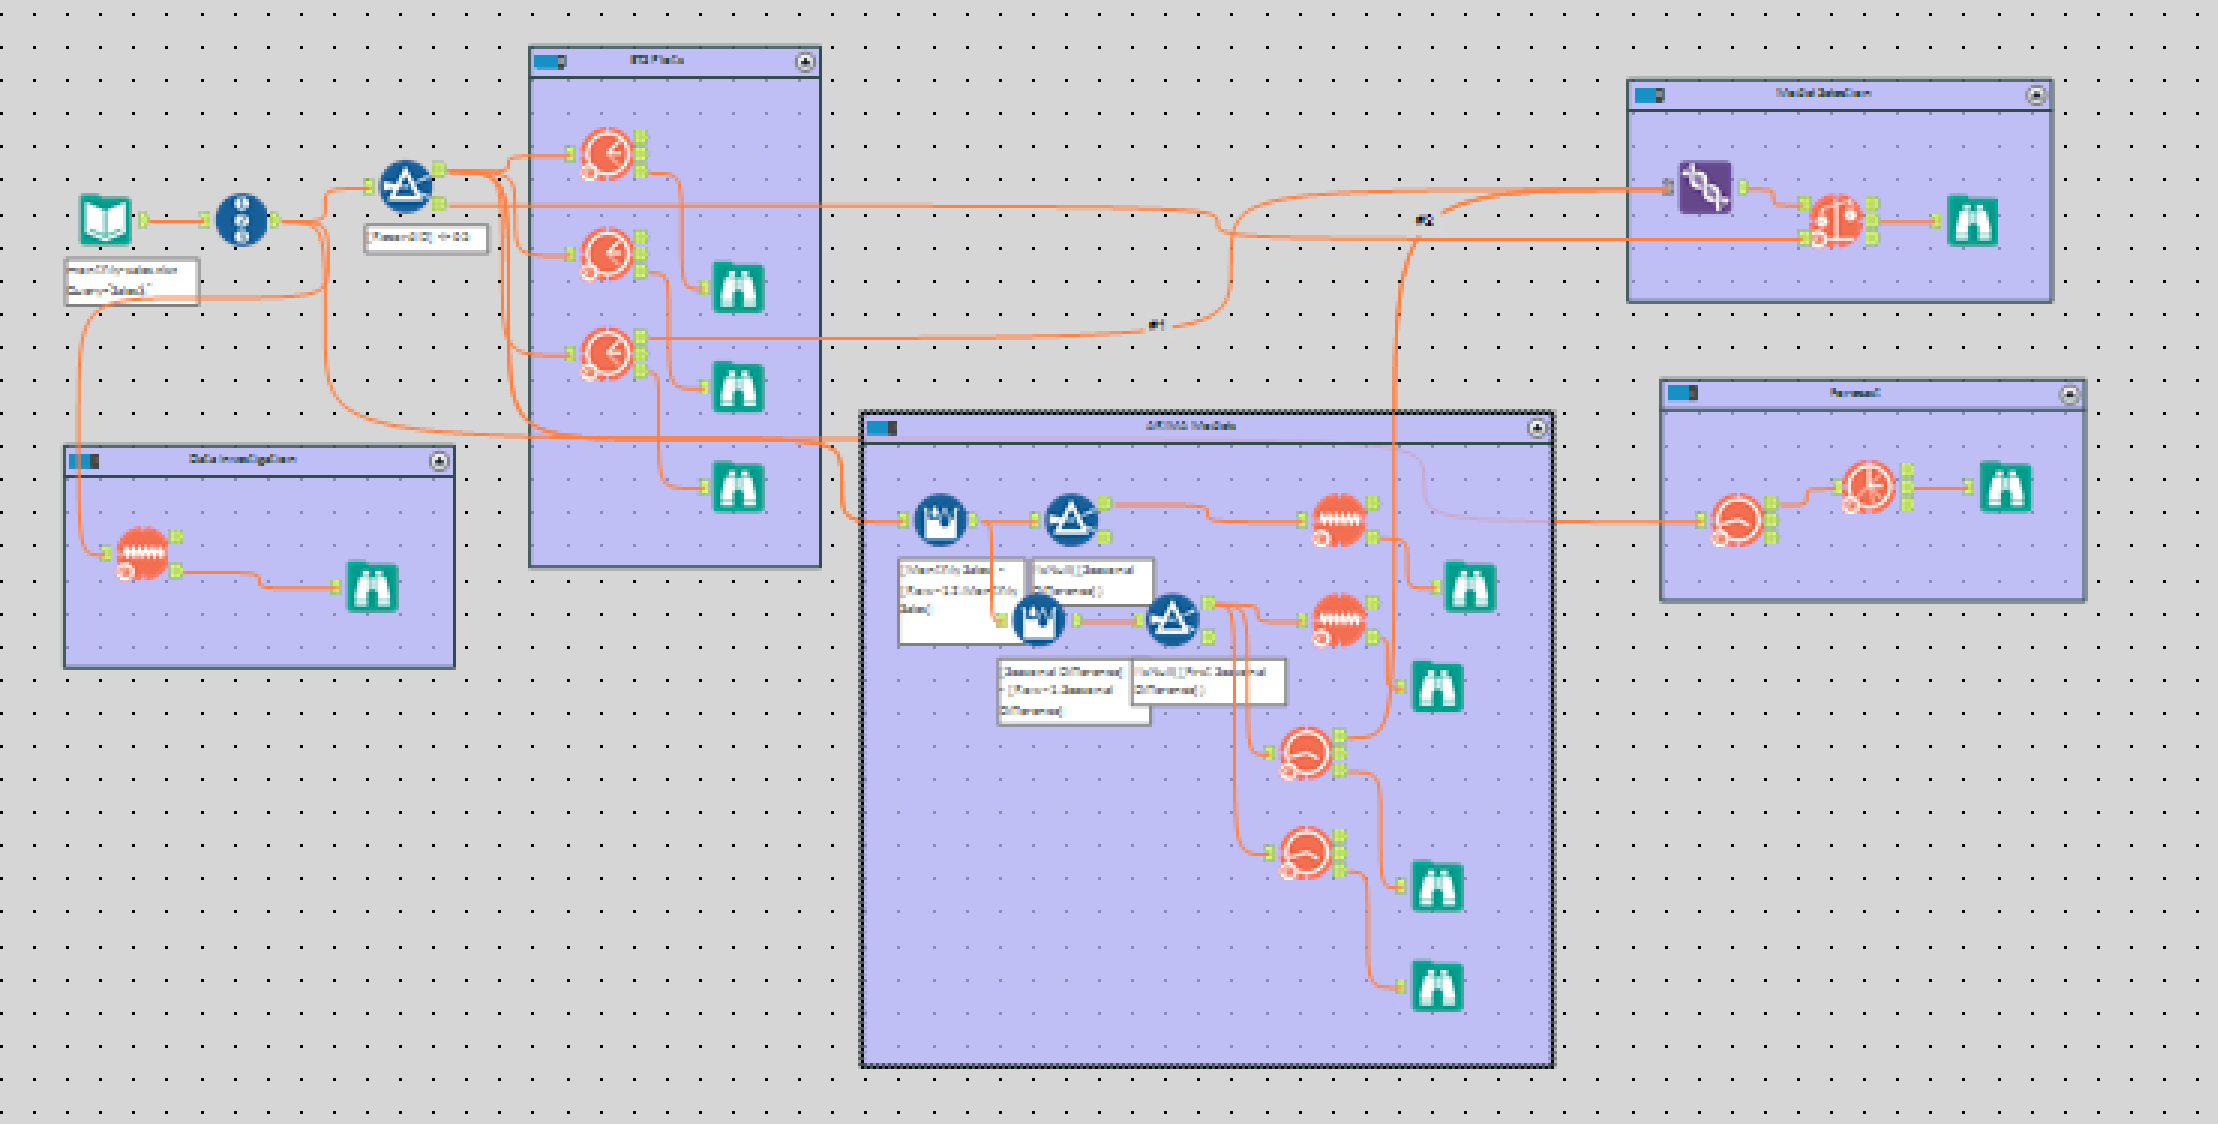

In [2]:
Image(os.listdir()[2])

In [3]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'alteryx_workflow_time_series_notebook.PNG',
 'links_for_reference.txt',
 'monthly-sales.xlsx',
 'README.md',
 'stationary_data_example.PNG',
 'Time_series.ipynb']

In [4]:
data = pd.read_excel(os.listdir()[4])

In [5]:
data.head()

,Month,Monthly Sales
0,2008-01,154000
1,2008-02,96000
2,2008-03,73000
3,2008-04,51000
4,2008-05,53000


In [6]:
print(data.shape)
print(data.columns)
print(data.isnull().any())

(69, 2)
Index(['Month', 'Monthly Sales'], dtype='object')
Month            False
Monthly Sales    False
dtype: bool


The first question that arises is how do I know by looking at the data that a time series model will be a good choice. Well there are certain characteristics that you will look for in your data before you go about applying models:

- Is the data in sequential intervals. Simply put is there a pattern to the dates. In our dataset we have data for each month. There is an order to it. If we have data at random from let's say Jan, Feb, Aug, Nov, we couldn't use it in our forecast model. 

- Order matters. It's an extension to our previous point. If were to switch 2 and 3rd row the data will change. It won't have the same meaning. It won't make any logical sense since the month of Feb cannot come before Jan of the same year.

- Single data points. Again this ties to the idea of data making logical sense. For the month of Jan, I cannot have an aggregate sales of 100 and 200. That doesn't sense.

So our data does hold true for all of the above points and hence it is a viable input. 

In [7]:
data['Month'] = pd.to_datetime(data['Month'])

In [8]:
data.head()

,Month,Monthly Sales
0,2008-01-01,154000
1,2008-02-01,96000
2,2008-03-01,73000
3,2008-04-01,51000
4,2008-05-01,53000


In [9]:
data.dtypes

Month            datetime64[ns]
Monthly Sales             int64
dtype: object

In [10]:
data.set_index(data['Month'], drop = True, inplace = True)

In [11]:
data.head()

,Month,Monthly Sales
Month,,
2008-01-01,2008-01-01,154000
2008-02-01,2008-02-01,96000
2008-03-01,2008-03-01,73000
2008-04-01,2008-04-01,51000
2008-05-01,2008-05-01,53000


In [12]:
data.drop(columns = ['Month'], inplace = True)

In [13]:
data.head()

,Monthly Sales
Month,
2008-01-01,154000
2008-02-01,96000
2008-03-01,73000
2008-04-01,51000
2008-05-01,53000


We need to set the frequency of our index. This step is essential since we will be using forecasting models. In simple words we are letting the model know what is the frequency which each data is seperated i.e. monthly 

In [14]:
data.index.freq = 'MS'

Let us now visualise our data and get a feel of how it looks like.

In [15]:
plt.style.available

<IPython.core.display.Javascript object>

['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 'tableau-colorblind10',
 '_classic_test']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

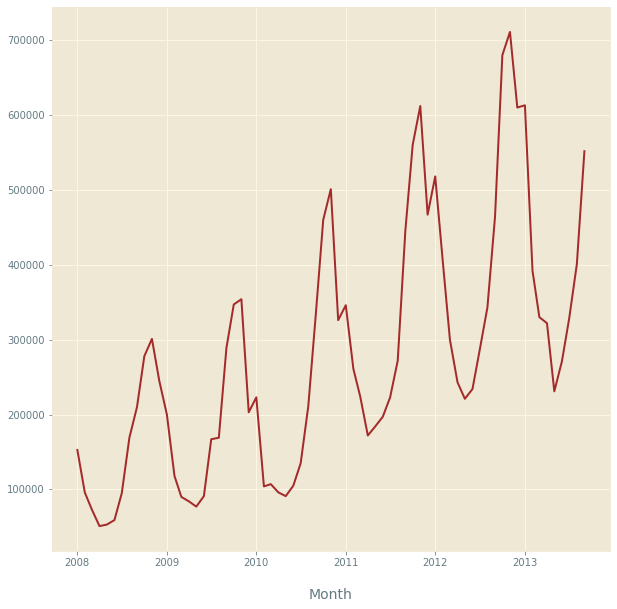

In [16]:
plt.figure(figsize = (10,10))
plt.style.use('Solarize_Light2')
plt.plot(data, color = 'brown')
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.show()

Let's say you aren't well aware of the various time series models and decide to use simplistic methods to forecast the data. The first method you decide to use is the average method where you average all the past values and assign the average value as the forecasted value. 

A important question here is that how will you know how good your forecast is?. You don't have any future data to reference against. Since we are tasked with forecating the sales for the next 4 periods, let us create a test set that contains the last 4 months of the data. That way we can predict on these months and then calculate how far off our model really is. 

In [17]:
test = data.iloc[65:,:]

In [18]:
test

,Monthly Sales
Month,
2013-06-01,271000
2013-07-01,329000
2013-08-01,401000
2013-09-01,553000


We have to make sure the model we train on does not contain the test set values.

In [19]:
train = data.iloc[0:65]

#remember when indexing using numbers, the last value of the range is included.

In [20]:
train.shape

(65, 1)

Let us make our first predictions.

In [21]:
series_values = train['Monthly Sales'].values.tolist()
average_method_prediction = []

for x in range(4):
    average = np.mean(series_values)
    average_method_prediction.append(average)
    series_values.append(average)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It makes sense that all the values are the same. Now let us see how good our predictions are. 

In [22]:
from sklearn.metrics import mean_squared_error

average_method_mse = mean_squared_error(test['Monthly Sales'], average_method_prediction)
average_method_rmse = average_method_mse ** (1/2)


In [23]:
print(average_method_mse)
print(average_method_rmse)

25245053017.751488
158886.91896361855


Let us make a df where we can store the error comparisons of the different models we will use, just to see our progression from a simple model to a complex model and how it affects error values. 

In [24]:
model_comparison = pd.DataFrame(columns = ['Model Name', 'MSE', 'RMSE'])

In [25]:
model_comparison

,Model Name,MSE,RMSE


In [26]:
model_comparison = model_comparison.append({'Model Name' : 'Average Method', 'MSE' : average_method_mse, 'RMSE' : average_method_rmse}, ignore_index=True)

In [27]:
model_comparison

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964


It is safe to say our forecast values are way off. To be specific off by almost 160000. Now that's not good is it. We think a little and decided to use another approach. What if I just assigned the forecast value to the same as the most recent period's value. The rationale is that there won't be that much of a difference in the sales from one month to the other. This approach is called the naive method. So let us try using that model.

In [28]:
train.tail()

,Monthly Sales
Month,
2013-01-01,613000
2013-02-01,392000
2013-03-01,330000
2013-04-01,322000
2013-05-01,231000


So the first prediction would be the value 231000. Since all of the rest are predictions as well, the value will pretty much be the same. You can already sense how wrong all of our approaches are but let us continue to make sure we document the error values. 

In [29]:
naive_method_predictions = [231000, 231000, 231000, 231000]

naive_method_mse = mean_squared_error(test['Monthly Sales'], naive_method_predictions)
naive_method_rmse = naive_method_mse ** (1/2)

print(naive_method_mse)
print(naive_method_rmse)

35947000000.0
189596.94090359157


In [30]:
model_comparison = model_comparison.append({'Model Name' : 'Naive Method', 'MSE' : naive_method_mse, 'RMSE' : naive_method_rmse}, ignore_index=True)
model_comparison

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964
1,Naive Method,3.594700e+10,189596.940904


Well apparently we seem to be getting worse with our predictions. This isn't good. There are other apporaches as well such as moving average method and seasonal naive method, but you get the picture already. 

So why is it that our values are so far off. Let's look at our plot again.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

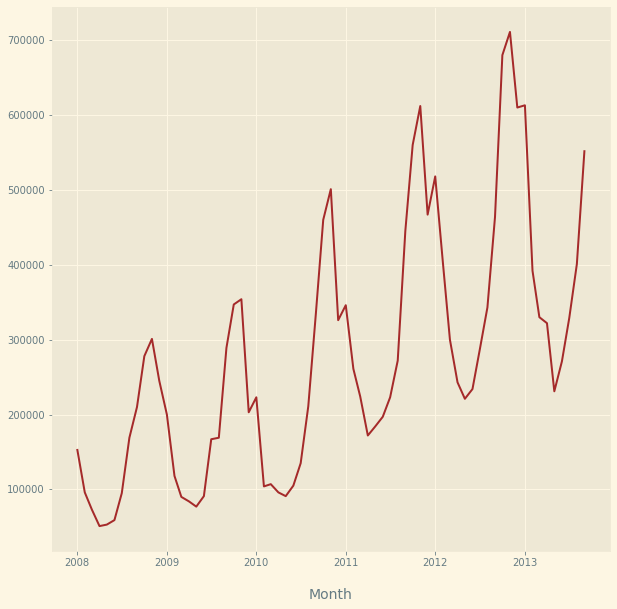

In [31]:
plt.figure(figsize = (10,10))
plt.style.use('Solarize_Light2')
plt.plot(data, color = 'brown')
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.show()

We can tell that there is a certain trend to the overall data. If I were to draw a line through it, it would show an upward trend. Similar we can see that there seasonality in out data. What is seasonality?. A trend tends to repeat itself over a specific amount of time. Based on our intervals, it can be weekly, monthly or yearly. In our data, the seasonality occurs every 12 months, where we see a spike in sales. If you are a hotel, you might see spike in sales every summer during vacation periods. If you sell jackets, witner season will bring in seasonality in sales. 

Considering both these factors, shouldn't it be logical to include trend and seasonality in our forecasts as well?. Hence let us start moving towards more complex models, that do take into account seasonality and trends. There are two models we will be working with, Exponential Smoothing and ARIMA.

For most time series models we would first need to deconstruct our time series. In simple words, viewing the trend and seasonality portion of the data as seperate graphs. 

### Time Series Plots:

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [33]:
decomposition = seasonal_decompose(data)

<IPython.core.display.Javascript object>

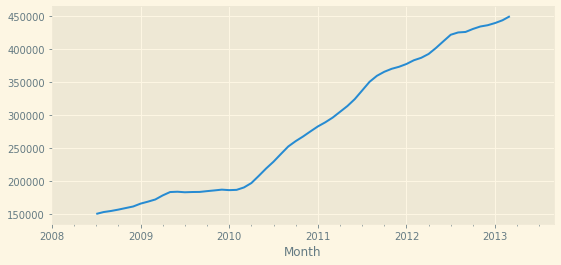

In [34]:
trend = decomposition.trend
trend.plot(legend = False, figsize = (9,4))
plt.show()

<IPython.core.display.Javascript object>

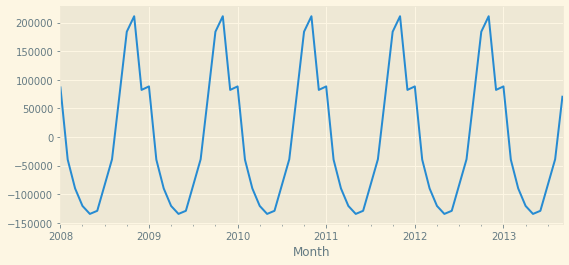

In [35]:
seasonal = decomposition.seasonal
seasonal.plot(legend = False, figsize = (9,4))
plt.show()

<IPython.core.display.Javascript object>

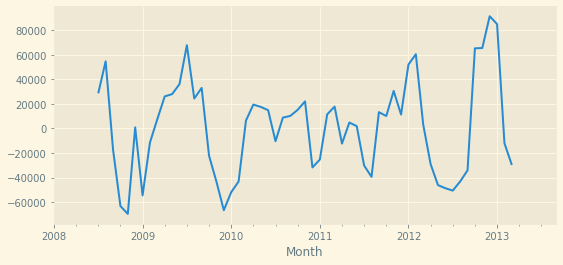

In [36]:
residual = decomposition.resid
residual.plot(legend = False, figsize = (9,4))
plt.show()

### Exponential Smoothing :

The Exponential Smoothing method takes weighted averages of past observations and adjusts for trend and seasonality. We assign an alpha value to each value. Alpha ranges from 0 - 1. If alpha is close to 1, we say recent values carry more weight towards our forecast than previous ones. 

The simplest model we can use is the Simple Exponential Smoothing. This is ideal for data with no seasonal or trend patterns. The equation for a SES  model can be written as 

**Forecast = Weight(previous month's value) + Weight(value from 2 months ago)+.........till oldest value**

**Weight = alpha(1 - alpha) ^ t  - where t is the time period. 0 means the most recent value and so on**

For anyone looking to further understand how SES can be implemented manually, you can click on this [link](https://docs.google.com/spreadsheets/d/13Rv9_hOLZswYb7uXh2thUsx1J11OE_A2SVwZqSIqm3I/edit?usp=sharing) where I apply SES manually to a sample dataset.

Choosing the alpha value is an iterative process, where you can calculate at what alpha value was the error lowest. Thankfully we have libraries that can do most of the legwork for us.

So we as the Business Analyst decide to try a Simple Exponential Smoothing method. We will use the stats models library extensively from now on. You can find the different classes [here](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing).

### Simple Exponential Smoothing : 

In [37]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(train)
#while it is always good to have the model decide the ideal parameters, we are trying out different values to understand better
ses_fit = ses_model.fit(smoothing_level=0.2)
#don't worry about the other parameters
ses_forecast = ses_fit.forecast(4)
ses_forecast

2013-06-01    394337.928406
2013-07-01    394337.928406
2013-08-01    394337.928406
2013-09-01    394337.928406
Freq: MS, dtype: float64

So we just made our first forecast using a more complex model. But is the value any good?. Let's play around with other values of alpha and see which one performs the best.

In [38]:
alpha_values = [0.2,0.5,0.7,0.9]

for alpha in alpha_values:
    model = SimpleExpSmoothing(train)
    fit = model.fit(smoothing_level=alpha)
    forecast = fit.forecast(4)
    mse = mean_squared_error(test, forecast)
    rmse = mse ** (1/2)
    
    print('For the value of alpha : {0}, the mse is : {1} and rmse is {2}'.format(alpha,mse,rmse))
    print('--------------------------')
    

For the value of alpha : 0.2, the mse is : 11174831408.07449 and rmse is 105711.07514387737
--------------------------
For the value of alpha : 0.5, the mse is : 18946153521.50373 and rmse is 137645.02723129423
--------------------------
For the value of alpha : 0.7, the mse is : 27010026691.457905 and rmse is 164347.2746700045
--------------------------
For the value of alpha : 0.9, the mse is : 33114612596.45163 and rmse is 181974.2086023501
--------------------------


It seems the alpha value of 0.2 seems to give the best model. Let us update our model comparison df and see how it compares to other error values. 

In [39]:
model_comparison.columns

Index(['Model Name', 'MSE', 'RMSE'], dtype='object')

In [40]:
model_comparison = model_comparison.append({'Model Name':'Simple Exponential Smoothing', 'MSE': 11174831408.07449, 'RMSE': 105711.07514387737 }, ignore_index = True)
model_comparison

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964
1,Naive Method,3.594700e+10,189596.940904
2,Simple Exponential Smoothing,1.117483e+10,105711.075144


We seem to be making progress but still not accurate enough. From the plots earlier we know there is a trend to the data. We know it shows seasonality. So a simple smoothing model isn't good enough. 

Let's move on to what we call Double Exponential or Holt's Linear Method. Here we incorporate the trend component additively. What do I mean by addiditively?. If I were to explain it using a simple equation: 

**Forecast = Simple Smoothing + Trend component**

I won't go into the maths behing the equation. If you wish to know more about it, I will post a few link to articles at the end of the notebook that explain it in more detail.

### Holt's Linear Method:

In [41]:
from statsmodels.tsa.holtwinters import Holt

beta_values = [0,0.05,0.2,0.4,0.6,0.8]

for beta in beta_values:
    hlm_model = Holt(train)
    hlm_fit = hlm_model.fit(smoothing_level = 0.25, smoothing_slope = beta)
    hlm_forecast = hlm_fit.forecast(4)
    hlm_mse = mean_squared_error(test, hlm_forecast)
    hlm_rmse = hlm_mse ** (1/2)
    
    print('For the value of beta : {0}, the mse is : {1} and rmse is {2}'.format(beta,hlm_mse,hlm_rmse))
    print('--------------------------')

For the value of beta : 0, the mse is : 10389594905.350863 and rmse is 101929.36233171904
--------------------------
For the value of beta : 0.05, the mse is : 11053338657.308273 and rmse is 105134.85938216817
--------------------------
For the value of beta : 0.2, the mse is : 14722711986.233097 and rmse is 121337.18303237922
--------------------------
For the value of beta : 0.4, the mse is : 30692490929.931175 and rmse is 175192.72510561382
--------------------------
For the value of beta : 0.6, the mse is : 97626773275.62265 and rmse is 312452.8336815377
--------------------------
For the value of beta : 0.8, the mse is : 305726163129.5486 and rmse is 552925.0972143954
--------------------------


In [42]:
model_comparison = model_comparison.append({'Model Name':'Holt\'s Linear Method', 'MSE': 10389594905.350863, 'RMSE': 101929.36233171904 }, ignore_index = True)
model_comparison

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964
1,Naive Method,3.594700e+10,189596.940904
2,Simple Exponential Smoothing,1.117483e+10,105711.075144
3,Holt's Linear Method,1.038959e+10,101929.362332


The problem with Holt's Linear method is that it assumes the trend will continue indefinitely. This can be a problem when we are forecasting longer periods into the future. The solution is to add a damping parameter (phi) which helps flatten out the trend line.

I am sure by now you can understand how our models are slowly gaining complexity. From the plots earlier we saw that there are some characteristics / components of a time series. It has a trend, a seasonal element and residual. So let us not move towards what we call the Triple Exponential or Holt's Winters Seasonal Smoothing Model. Sounds like a mouthful!. In simple we are accounting for all the components of our time series. 


So how do we factor in the components?. Now we can do it one of two ways, Additively or Multiplicatively. So our final equation looks something like this : 

**Forecast = Trend level + Seasonality + Residual or** 

  **Forecast = Trend level * Seasonality * Residual**
  
Now I didn't dwell into the maths behind it. We have libraries that will do most of those calculations. What matters is we understand why we are choosing a particular model and how to factor in the different components of the time series data.

So the question now is how do I know when how to apply the components i.e. additively or multiplicatively. There are various explanations to it. The way I learned it is through visual cues which is by far the easiest: 

 - If the trend is realtively linear or constantly increasing or decreasing, then use additively. If the trend increases or        decreases in magnitude over time use multiplicatively.
 - If the seasonality is relatively constant, use additively. If the magnitude changes over time then use multiplicatively. 
 - If there is no particular trend or pattern, we do not factor it in the equation. 
 - If the residuals is constant, then addidtively. If it increase or decreases in magnitude then multiplicatively.
 
Let us plot our decomposition again to see how each component can be included in the equation. 

<IPython.core.display.Javascript object>

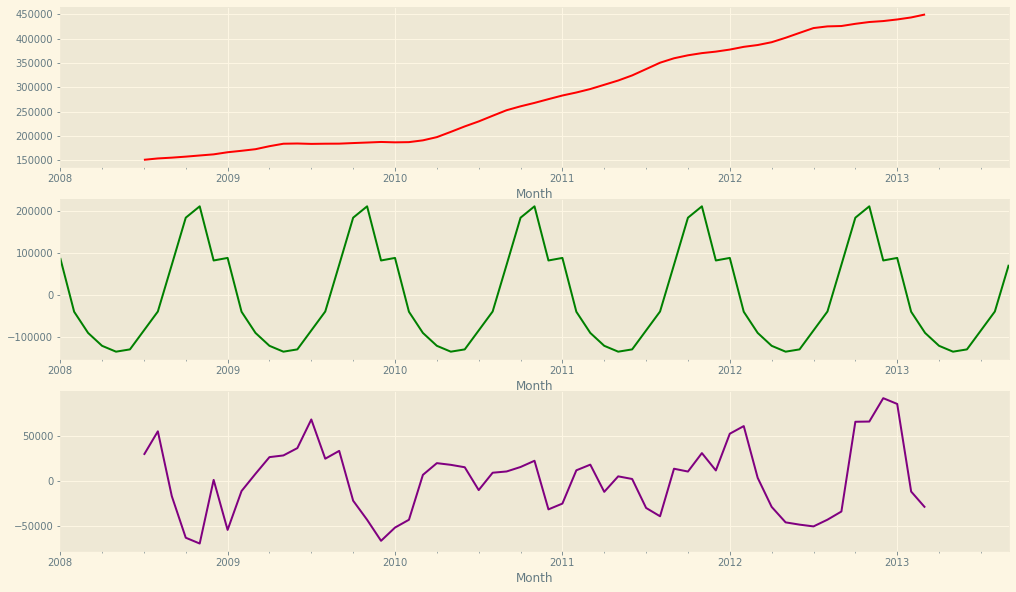

In [43]:
fig, ax = plt.subplots(3,1, figsize = (17,10))
decomposition.trend.plot(ax = ax[0], legend = False, color = 'red')
decomposition.seasonal.plot(ax = ax[1], legend = False, color = 'green')
decomposition.resid.plot(ax = ax[2], legend = False, color = 'purple')

### Holt-Winter's Seasonal Model:

Take a moment and carefully view each graph. How do you think each component should be included as?. 

- Uptrend constantly - Additively
- Seasonality looks constant - Additively
- Residuals increasing and decreasing in magnitude - Multiplicatively

So our model can be denoted as - ETS(MAA)

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hws_model = ExponentialSmoothing(train, trend = 'add' , seasonal = 'add' , seasonal_periods=12)
hws_fit = hws_model.fit()
hws_forecast = hws_fit.forecast(4)
hws_mse = mean_squared_error(test, hws_forecast)
hws_rmse = hws_mse ** (1/2)
hws_rmse

C:\Users\hamza\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


18686.273828985344

See how our error value drops drastically. Let us visualise our forecasted values.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

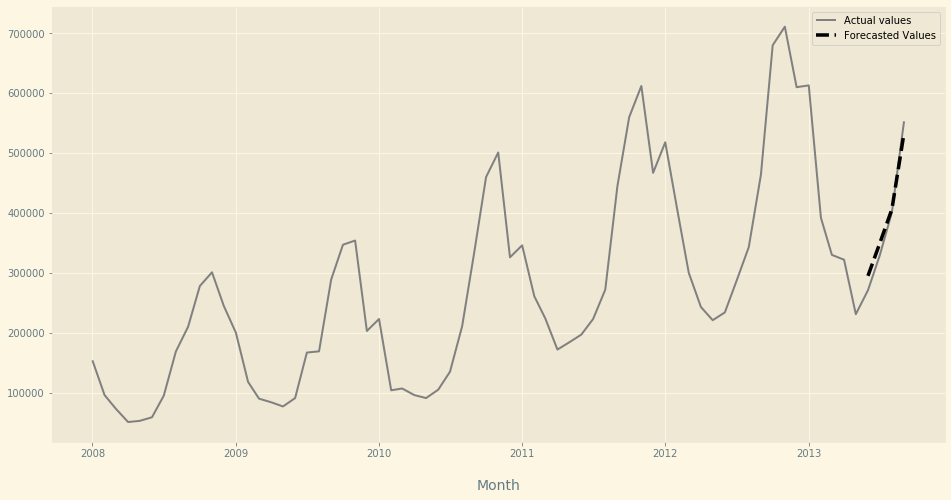

In [45]:
plt.figure(figsize = (16,8))
plt.plot(data, color = 'grey', label = "Actual values")
plt.plot(hws_forecast, color = 'black', linestyle = '--', label = "Forecasted Values", linewidth = 3.5)
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.legend()
plt.show()

Looks like our forecasted values are pretty close to our actual values. That means the model is doing a pretty good job. Let us update our model comparison table.

In [46]:
model_comparison = model_comparison.append({'Model Name':'ETS(MAA)', 'MSE': hws_mse, 'RMSE': hws_rmse }, ignore_index = True)
model_comparison

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964
1,Naive Method,3.594700e+10,189596.940904
2,Simple Exponential Smoothing,1.117483e+10,105711.075144
3,Holt's Linear Method,1.038959e+10,101929.362332
4,ETS(MAA),3.491768e+08,18686.273829


Let us now look at the workings of an ARIMA model. ARIMA stands for Auto Regressive Integrated Moving Average. Let's stick with ARIMA for ease. Before we understand what an ARIMA model is, we need to understand the concept of stationarity. 

In the context of time series, stationarity refers to data having a constant mean, variance and co variance. Having a stationary dataset gives you two advantages. First it makes predictions easier. Second, it makes our predictions accurate. Let us understand it with a real life example. Let's say if we have a pitcher. He has 6 different types of pitches he usually throws (please forgive my lack of baseball knowledge). If we view his pitching pattern long enough, we will be able to predict what his next pitch might be with a certain level of accuracy.

So how do we check for stationarity. Well there are several methods but I would list the ones that I find the easiest :

- Shape of the plot 
- Rolling statistics 
- Using ACF plot

Let us go thorugh each method step by step. You can judge whether a data is stationary just by looking at the plot. Here is what a stationary data set looks like:

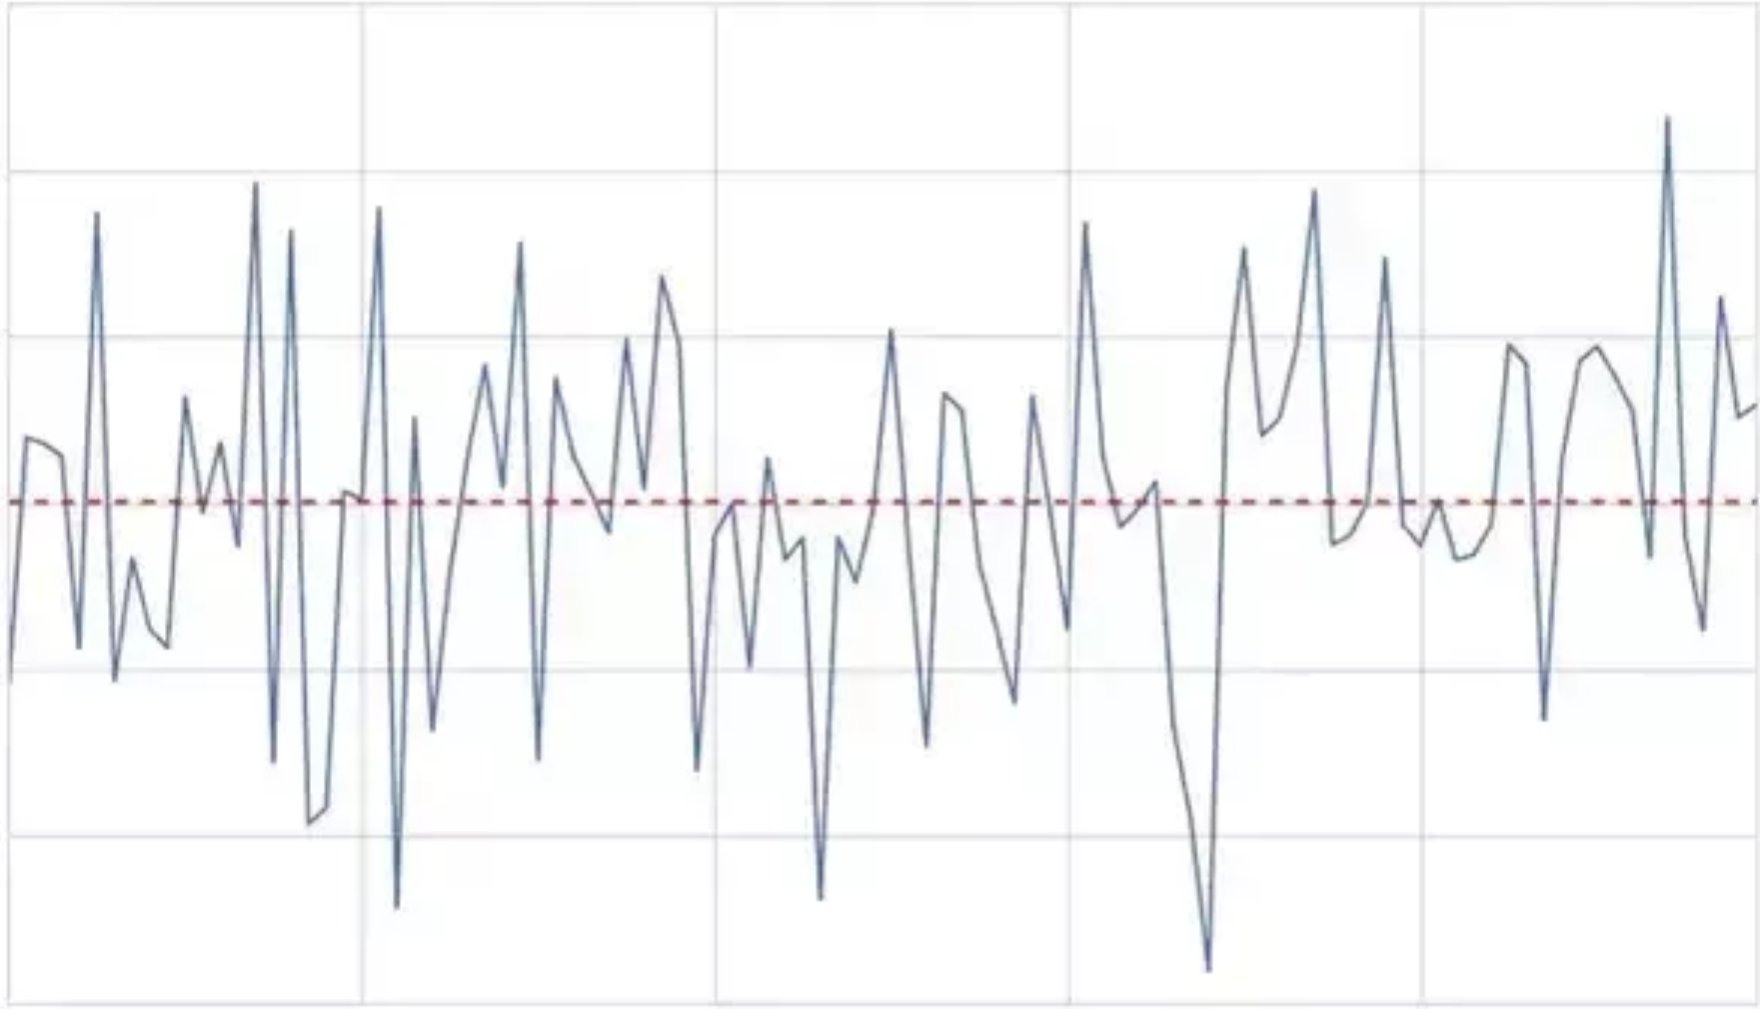

In [47]:
Image(os.listdir()[6], width = 417, height = 417)

As you can the data oscialltes around a constant mean. Looking at the plot of our sales data we can say for sure that our data is not stationary.

Another great visual cue is plotting the rolling statistics. If the mean shows a trend, then we know that our data is not stationary.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

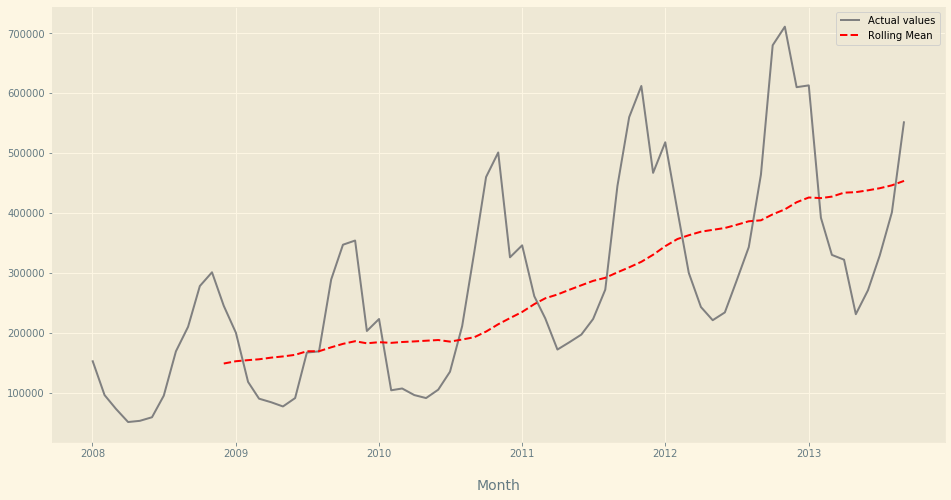

In [48]:
plt.figure(figsize = (16,8))
plt.plot(data, color = 'grey', label = "Actual values")
plt.plot(data.rolling(window = 12).mean(), label = "Rolling Mean", linestyle = '--', color = 'red')
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.legend()
plt.show()

The last method we will look at are ACF plots. Auto correlation plots shows the auto correlation of the series with lags of itself. The word lag will be used often in time series. Lags of itself in simple words refers to shifting the time series forward by some value. So a lag of 1 means shifting the time series forward by 1. 

We want no correlation between a time series and lags of itself. If the ACF plot shows a decay, then that means the series is correlated with lags of itself and hence it isn't stationary.



In [49]:
#calculating lags
print(data.head())
print(data.shift(periods = 1).head())

            Monthly Sales
Month                    
2008-01-01         154000
2008-02-01          96000
2008-03-01          73000
2008-04-01          51000
2008-05-01          53000
            Monthly Sales
Month                    
2008-01-01            NaN
2008-02-01       154000.0
2008-03-01        96000.0
2008-04-01        73000.0
2008-05-01        51000.0


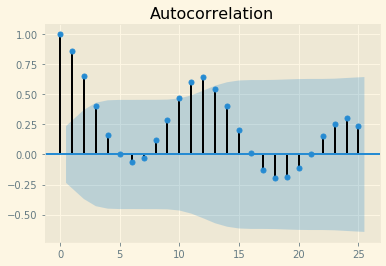

In [50]:
from statsmodels.graphics.tsaplots import plot_acf

acf_plot = plot_acf(data, lags = 25)

The correlation of 1 at lag 0 is correct, since any series correlated with itself is always 1. But look at the decay as we increase the lags. There is strong correlation at lag 2,3. Ideally we would want the lag values to have a correlation of 0.2 or lower showing weak or no correlation. Looking at ACF plot above we can tell our data is not stationary.

One of the pre requisites of an ARIMA models is that the data should be stationary. We know how to identify stationarity. Let us now look at how we can make unstationary data stationary. There are many methods of doing it but usually the differencing method works well most of the time. 

Differencing is subtracting the current value minus the previous value. So differencing for the month of Feb would be value of Feb - value of Jan. 

In [51]:
print(data.head())
print(data.diff(periods = 1).head())

            Monthly Sales
Month                    
2008-01-01         154000
2008-02-01          96000
2008-03-01          73000
2008-04-01          51000
2008-05-01          53000
            Monthly Sales
Month                    
2008-01-01            NaN
2008-02-01       -58000.0
2008-03-01       -23000.0
2008-04-01       -22000.0
2008-05-01         2000.0


Let us plot the results of differencing.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

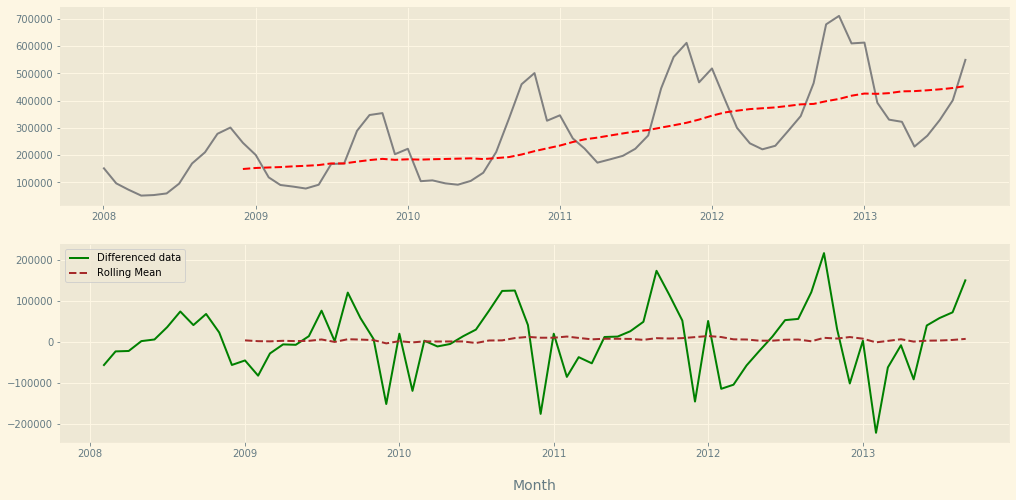

In [52]:
fig, ax = plt.subplots(2,1, figsize = (17,8))
ax[0].plot(data, color = 'grey', label = "Actual values")
ax[0].plot(data.rolling(window = 12).mean(), label = "Rolling Mean", linestyle = '--', color = 'red')

ax[1].plot(data.diff(periods = 1), label = "Differenced data", color = 'green')
ax[1].plot(data.diff(periods = 1).rolling(window = 12).mean(), linestyle = '--', label = "Rolling Mean", color = 'brown')

plt.legend()
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.show()

You can see the effects of differencing and how it helps the data become stationary. If the first differencing doesn't work, we can continue to difference. Be careful here though. The second difference will the difference of the first difference. It sounds confusing. [Here](https://docs.google.com/spreadsheets/d/1-IfOW2EdiGOqCXXKlchZAxvSE8O1tH7EKr6BXGly-Q4/edit?usp=sharing) is a link that shows how first and second differencing is applied to a sample dataset. 

So how does an ARIMA model work. There are 3 components to an ARIMA model : 

Auto Regressive or AR - AR models act like linear regression models. The difference here is that the feature are the lagged values of the time series. AR models use p to denote the lag component which means the number of lagged values to use in our model. So if p = 2, we will have to build a model using values for the past two months.

Moving Average or MA - Built like linear regression models but the difference here is that we will use lagged forecasted errors as features. MA models use q to denote the lag component. 

Integrated component - This refers to the number of times we had to difference to make our data stationary. This is denoted as d. So if d = 1, that means we differenced our series one time.

When combined ARIMA models are denoted as ARIMA(p,d,q). 

We have covered a lot so let us revise the steps that we will take build an ARIMA model. Lastly let us also assign some rules that will help us choose p,d,q terms. 



### ARIMA Guide:

1) Plot the time series decomposition plot. Try to judge whether the data is stationary or not. 

2) Validate your judgement using rolling statistics and ACF Plot.

3) If the data is non stationary, calculate first difference and plot. Continue until data is stationary.
      - Helper : If the ACF plot of the differenced data still shows significant correlation at lag 1,2,3 so on, then we need difference further. If the ACF plot drops after lag 0, auto correlation are small and patternless or is negative at lag 1 then that means our data is stationary. If the negative auto correlation exceeds -0.5 that means we have over differenced.

4) Decide upon what model component to use i.e AR or MA.

5) We will choose an AR model if the lag 1 of the ACF plot of the differenced series is positive or PACF plot drops quickly.
   PACF plots are partial auto correlation plots. PACF denotes the amount of correlation between a series and a lag of itself      that is not explained by correlations at all lower-order lags.

6) We will choose an MA model when the lag 1 of the ACF plot of the differenced series is negative or PACF decays.

7) Choose the appropraite terms and build the model. example ARIMA(0,1,1) or ARIMA (1,1,0).

8) Calculate error value. Plot the forecast with the confidence intervals.

So let us build our first ARIMA model. 

### ARIMA Model:

In [53]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [54]:
train['Sales Diff'] = train.diff(periods = 1)

C:\Users\hamza\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
train.head()

,Monthly Sales,Sales Diff
Month,,
2008-01-01,154000,NaN
2008-02-01,96000,-58000.0
2008-03-01,73000,-23000.0
2008-04-01,51000,-22000.0
2008-05-01,53000,2000.0


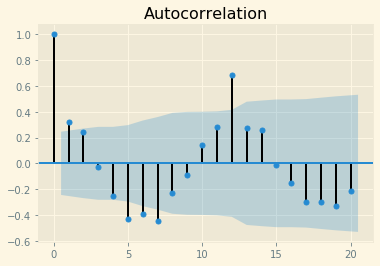

In [59]:
acf_1 = plot_acf(train['Sales Diff'][1:], lags = 20)

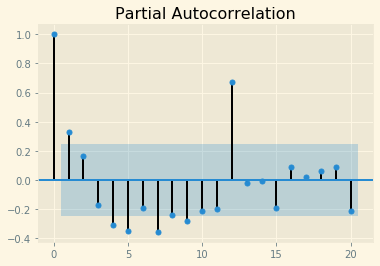

In [60]:
pacf_1 = plot_pacf(train['Sales Diff'][1:], lags = 20)

There is still some auto correlation but we will ignore that for now just to build our first ARIMA model.

In [76]:
train.tail()

,Monthly Sales,Sales Diff
Month,,
2013-01-01,613000,3000.0
2013-02-01,392000,-221000.0
2013-03-01,330000,-62000.0
2013-04-01,322000,-8000.0
2013-05-01,231000,-91000.0


In [89]:
arima_1 = ARIMA(train['Sales Diff'][1:], order = (1,1,0))
arima_1_fit = arima_1.fit()
arima_1_results = arima_1_fit.forecast(steps = 4)
arima_1_results

#the forecast result from the ARIMA is a little different than the result from an exponential.
#the first array is our forecast results.

(array([-55866.29813092, -71806.17028993, -65665.04504742, -69070.35268188]),
 array([ 83898.17030416,  96473.45667623, 115390.62953062, 128492.80087104]),
 array([[-220303.69029588,  108571.09403405],
        [-260890.67083942,  117278.33025956],
        [-291826.52308085,  160496.432986  ],
        [-320911.6146618 ,  182770.90929803]]))

In [90]:
arima_1_mse = mean_squared_error(test, arima_1_results[0])
arima_1_rmse = arima_1_mse ** (1/2)
arima_1_rmse

466967.59816693

It's like we have gone back to square one. The error value is massively high. Before you give up on ARIMA models, remember this was just to give an idea on how to code an ARIMA model.

By now you have a good idea as to how to interpret graphs and build an ARIMA model. Now let us introduce the concept of seasonal ARIMA models. Another one ! Before you decide this way too many models, seasonal ARIMA isn't that hard to understand. Seasonal ARIMA or SARIMA consists of two components, a non seasonal part (p,d,q) and a seasonal part (P,D,Q). 

In SARIMA the data is differced using 12 lags. Since our data frequency is 1 month, we take 12 lags, if it was quarterly we would take 4 lags. The AR and MA of SARIMA behave very similarly to its non seasonal counter parts. In fact the same rules that we used in ARIMA can be used to decided upon terms in SARIMA. The differrence here is that our ACF and PACF plots will use data with seasonal differencing.

Here is a guide for SARIMA : 

1) Seasonally difference the data : data.diff(periods = 12)
2) Check if data has become stationary. If not try the first difference of the seasonal difference. 
3) Generate ACF and PACF plots
4) Allot MA or AR terms using the rules of non seasonal ARIMA. 
5) Allot seasonal MA or AR terms by looking at only the lag intervals i.e. 12, 24 etc. So if the lag 12 in the ACF plot is positive then seasonal AR. 

Let us code the model so we can understand the conepts better. 

### Seasonal ARIMA : 

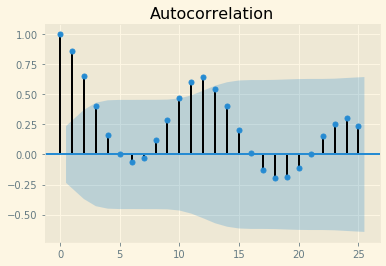

In [91]:
#acf plot for the original dataset 

acf_plot

In [95]:
# we can clearly see the data is not stationary. Let us seasonally difference the data 

train['Seasonal Diff'] = train['Monthly Sales'].diff(periods = 12)
train.head(15)

C:\Users\hamza\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Monthly Sales,Sales Diff,Seasonal Diff
Month,,,
2008-01-01,154000,NaN,NaN
2008-02-01,96000,-58000.0,NaN
2008-03-01,73000,-23000.0,NaN
2008-04-01,51000,-22000.0,NaN
2008-05-01,53000,2000.0,NaN
2008-06-01,59000,6000.0,NaN
2008-07-01,95000,36000.0,NaN
2008-08-01,169000,74000.0,NaN
2008-09-01,210000,41000.0,NaN


In [97]:
train_clean = train[['Seasonal Diff']].dropna()

<IPython.core.display.Javascript object>

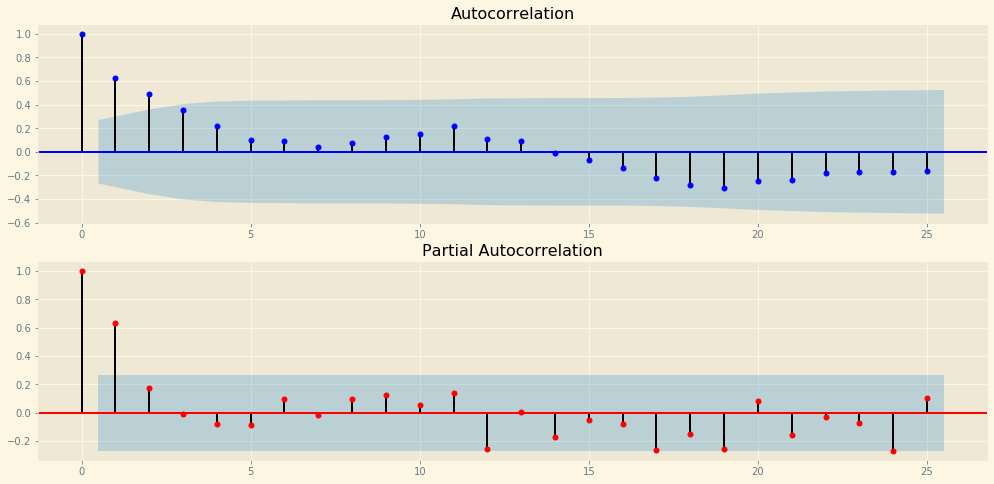

In [104]:
#let us plot the acf and pacf plots using the seasonally differenced data 
fig, ax = plt.subplots(2,1, figsize = (17,8))
acf_seasonal = plot_acf(train_clean, color = 'blue', ax = ax[0], lags = 25)
pacf_seasonal = plot_pacf(train_clean, color = 'red', ax = ax[1], lags = 25)


We can see our data is still stationary. So let us now take the first difference of the seasonal difference and see if we can reduce the auto correlation. 

In [105]:
train_clean.head()

,Seasonal Diff
Month,
2009-01-01,46000.0
2009-02-01,22000.0
2009-03-01,17000.0
2009-04-01,33000.0
2009-05-01,24000.0


In [106]:
train_clean['First Diff'] = train_clean.diff(periods = 1)
train_clean.head()

,Seasonal Diff,First Diff
Month,,
2009-01-01,46000.0,NaN
2009-02-01,22000.0,-24000.0
2009-03-01,17000.0,-5000.0
2009-04-01,33000.0,16000.0
2009-05-01,24000.0,-9000.0


<IPython.core.display.Javascript object>

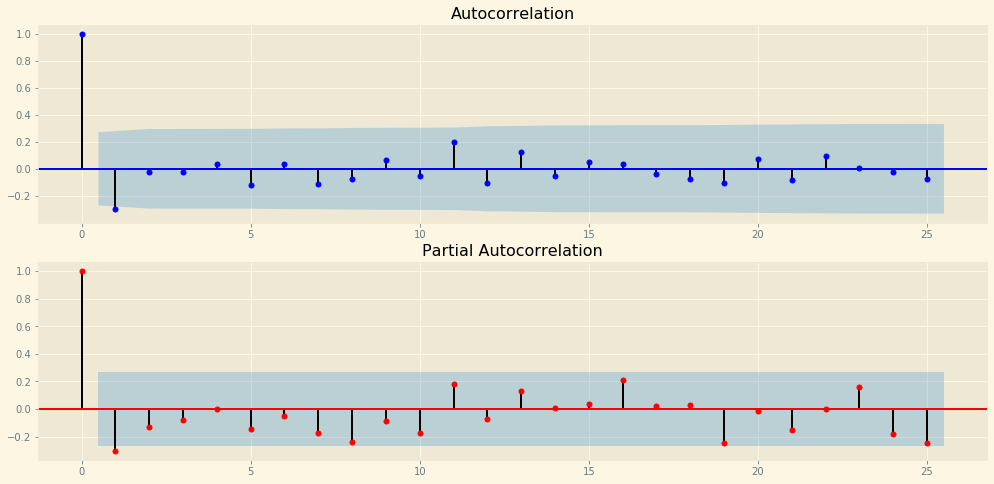

In [108]:
fig, ax = plt.subplots(2,1, figsize = (17,8))
acf_seasonal = plot_acf(train_clean['First Diff'][1:], color = 'blue', ax = ax[0], lags = 25)
pacf_seasonal = plot_pacf(train_clean['First Diff'][1:], color = 'red', ax = ax[1], lags = 25)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

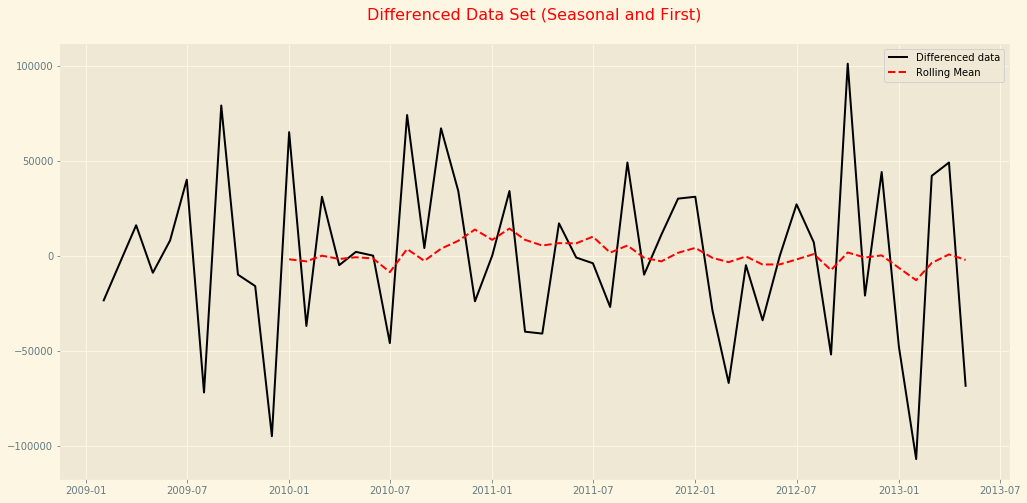

In [132]:
plt.figure(figsize = (17,8))
plt.plot(train_clean['First Diff'], label = "Differenced data", color = 'black')
plt.plot(train_clean['First Diff'].rolling(window = 12).mean(), linestyle = '--', label = "Rolling Mean", color = 'red')
plt.title('Differenced Data Set (Seasonal and First)', pad = 25, color = 'red')
plt.legend()

Let us decide on the values of each component we will use in our model. 

- Lag is negative and pacf is negative and decaying which means q(1) is appropriate.
- We took the first difference hence d(1).
- At lag 12 in the acf, there is no significant value at lag 12 hence no values for MA or AR.
- We seasonally differenced our data once hence D(1).

So our model will be SARIMA(0,1,1)(0,1,1)m=12. m is the number of periods in the season. LEt us built it. The SARIMA model is in the statespace library whose documentation can be found [here](https://www.statsmodels.org/stable/statespace.html#statespace).

In [158]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

sarima_model = SARIMAX(train_clean['First Diff'][1:], order = (0,1,1), seasonal_order = (0,1,0,12), enforce_invertibility = False, enforce_stationarity = False)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps = 4)
sarima_mse = mean_squared_error(test, sarima_forecast)
sarima_rmse = sarima_mse ** (1/2)
sarima_rmse

419175.52133885346

In [162]:
import statsmodels.api as sm 

In [163]:
sm.tsa.arima.model.ARIMA

AttributeError: module 'statsmodels.tsa.api' has no attribute 'arima'